# Malaria Cell Classification Project

In this notebook, we build a **Convolutional Neural Network (CNN)** from scratch to classify blood cell images as *infected* or *uninfected* by malaria parasites.  
The dataset is taken from the **NIH / NLM Malaria Cell Images** collection, publicly available on Kaggle.  

This project aims to:
- explore the full image classification pipeline (data loading → training → evaluation)
- understand how CNNs detect visual patterns in biomedical images and familiarize with deep learning architectures


In [1]:
!pip install numpy==1.26.4 --force-reinstall -q
!pip install torch torchvision matplotlib torchcam kagglehub -q

import torch, torchvision, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    import subprocess, textwrap, sys
    try:
        print(subprocess.check_output(["nvidia-smi"]).decode())
    except Exception as e:
        print("[warn] nvidia-smi not available:", e)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Using device: cuda
Mon Oct  6 17:53:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name       

## Dataset Download and Structure

We use the Kaggle dataset *Cell Images for Detecting Malaria*, which contains **27,558 images** divided into two folders:
- `Infected` (cells containing malaria parasites)
- `Uninfected` (healthy red blood cells)

Each image is a small RGB crop taken under a microscope.  
We’ll download the dataset directly using the `kagglehub` library and inspect its structure.


In [2]:
# Dataset downwload (open source Kaggle Malaria Cell Images Dataset)

import kagglehub, os
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
print("Dataset downloaded to:", path)

data_path = os.path.join(path, "cell_images")

# Transforms (3-channel normalization)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load raw classes and collapse
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader

_raw = ImageFolder(root=data_path, transform=transform)

POSITIVE = {"Infected", "Parasitized"}
NEGATIVE = {"Uninfected"}

name_to_label = {}
for cname in _raw.classes:
    if cname in POSITIVE: name_to_label[cname] = 1
    elif cname in NEGATIVE: name_to_label[cname] = 0
    else: name_to_label[cname] = None

filtered_samples = []
for (p, old_idx) in _raw.samples:
    cname = _raw.classes[old_idx]
    nl = name_to_label.get(cname, None)
    if nl is not None:
        filtered_samples.append((p, int(nl)))


class CollapsedImageDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        self.loader = default_loader
        self.classes = ["Uninfected", "Infected"]
        self.class_to_idx = {"Uninfected":0, "Infected":1}

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = self.loader(path)
        if self.transform: img = self.transform(img)
        return img, target

dataset = CollapsedImageDataset(filtered_samples, transform=transform)

print(f"Total images (filtered): {len(dataset)} | Classes: {dataset.classes} | Mapping: {dataset.class_to_idx}")


Using Colab cache for faster access to the 'cell-images-for-detecting-malaria' dataset.
Dataset downloaded to: /kaggle/input/cell-images-for-detecting-malaria
Total images (filtered): 27558 | Classes: ['Uninfected', 'Infected'] | Mapping: {'Uninfected': 0, 'Infected': 1}


## Train/Test Split

We split the dataset into:
- **80% training data**, used by the model to learn patterns.
- **20% test data**, used to evaluate generalization.

A `DataLoader` is created to feed the images to the CNN in small batches during training.


In [3]:
# Split 80/20
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False, num_workers=2, pin_memory=(device=="cuda"))


## Model Architecture

We define a simple Convolutional Neural Network (CNN) with:
- two convolutional layers (`Conv2d + ReLU + MaxPool`),
- one fully connected hidden layer,
- and one final neuron producing a single *logit* (for binary classification).

This small model is powerful enough to detect color and texture patterns that differentiate infected from uninfected cells.


In [4]:
# CNN implementation

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*16*16, 128), nn.ReLU(),
            nn.Linear(128, 1)  # logits
        )
    def forward(self, x): return self.fc(self.conv(x))

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

model = SimpleCNN().to(device)
model.apply(init_weights)
sum_params = sum(p.numel() for p in model.parameters())
print(f"Model params: {sum_params:,}")


Model params: 1,053,921


## Model Training

We train the network for 5 epochs using:
- **Adam optimizer** with a learning rate of `1e-4`
- **Binary Cross Entropy with Logits Loss** (`BCEWithLogitsLoss`)
  
During each epoch, the model updates its parameters to minimize prediction errors between its outputs and the ground-truth labels.


In [5]:
# Model training on 5 epochs
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

for epoch in range(5):
    model.train()
    running = 0.0
    for X, y in train_loader:
        X = X.to(device, non_blocking=True)
        y = y.to(torch.float32).unsqueeze(1).to(device, non_blocking=True)  # [B,1] in {0,1}

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running += float(loss.detach().cpu())
    print(f"Epoch {epoch+1}: loss = {running/len(train_loader):.6f}")


Epoch 1: loss = 0.569996
Epoch 2: loss = 0.419520
Epoch 3: loss = 0.349482
Epoch 4: loss = 0.307032
Epoch 5: loss = 0.278205


After a few epochs, the loss progressively decreases, meaning the CNN is learning to differentiate the two cell types.  
We can now evaluate the trained model on the test set to check its real performance.
To do so, we compute:
- the **accuracy** (percentage of correct predictions),
- and display a **confusion matrix** to see which types of errors occur.


Accuracy: 0.896


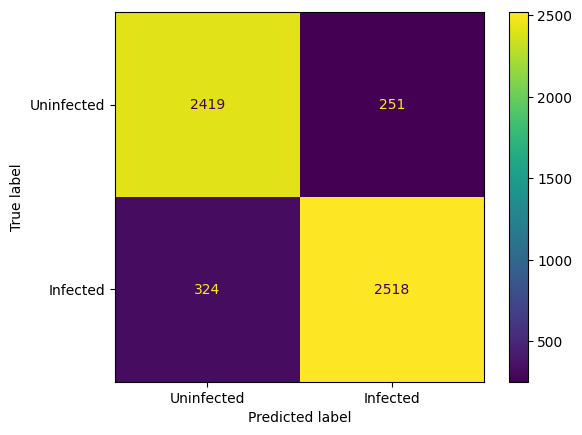

In [6]:
# Results

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device, non_blocking=True)
        logits = model(X)
        probs = torch.sigmoid(logits).cpu()
        preds = (probs > 0.5).int().squeeze(1)
        y_true.extend(y.numpy())
        y_pred.extend(preds.numpy())

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", round(acc, 3))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=dataset.classes).plot()
plt.show()


## Model Analysis

Visual inspection helps understand the model’s behavior.
Below, we show examples of **false positives** (healthy cells classified as infected) and **false negatives** (infected cells missed by the model).

This helps identify what kinds of visual features the CNN finds confusing.


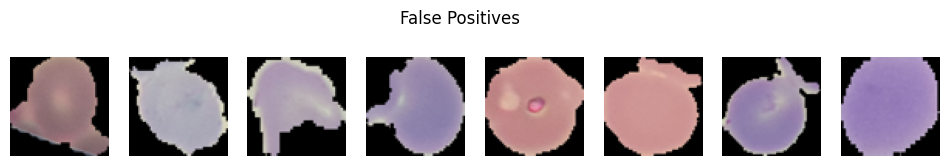

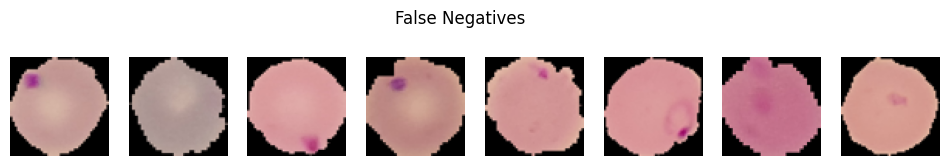

In [7]:
# Insightful display of false positives/negatives

import random
import numpy as np
from PIL import Image

preds, paths, ytrue = [], [], []
idx = 0
with torch.no_grad():
    for X,y in test_loader:
        b = X.size(0)
        logits = model(X.to(device))
        p = (torch.sigmoid(logits).cpu().numpy().ravel() > 0.5).astype(int)
        preds.extend(p.tolist())
        ytrue.extend(y.numpy().tolist())
        for i in range(b):
            paths.append(test_data.indices[idx + i])
        idx += b

def show_samples(mask, title):
    ids = [i for i,m in enumerate(mask) if m]
    ids = random.sample(ids, min(8, len(ids)))
    plt.figure(figsize=(12,2))
    for k,i in enumerate(ids,1):
        img_path,_ = dataset.samples[paths[i]]
        img = Image.open(img_path).convert("RGB").resize((64,64))
        plt.subplot(1,len(ids),k); plt.imshow(img); plt.axis("off")
    plt.suptitle(title); plt.show()

fp_mask = [(ytrue[i]==0 and preds[i]==1) for i in range(len(preds))]
fn_mask = [(ytrue[i]==1 and preds[i]==0) for i in range(len(preds))]
show_samples(fp_mask, "False Positives")
show_samples(fn_mask, "False Negatives")


## Conclusion

This notebook was created to understand the core principles of image classification with CNNs.

Through this project, we learned how to:
- preprocess and structure a real medical image dataset,
- train a neural network from scratch,
- evaluate and visualize its predictions,
- and interpret its decision-making process.

This work can serve as a foundation for more advanced projects, such as transfer learning or clinical-grade parasite detection systems.
